# <h1><center> Homework 2 Assignment </center></h1>
### <h2><center> Computer Music Representations and Models Course </center></h2>
#### <h3><center> Acoustics Engineering @ Politecnico di Milano </center></h3>


In [190]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import librosa
import IPython.display as ipd
import csv

##### Question 1
<!-->in this element is loaded the main answer to the first question<!-->
Implementation of _template based chord recognition function_. Given an audio file, and some control parameters as the input of the function, it will extrapolate the chord sequence based on the audio feature extrapolation 

In [191]:
def stft_basic(x, w, H=8):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize

    Returns:
        X: The discrete short-time Fourier transform
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int)
    X = np.zeros((N, M + 1), dtype='complex')
    for m in range(M + 1):
        x_win = x[m * H:m * H + N] * w
        X_win = np.fft.fft(x_win)
        X[:, m] = X_win
    K = (N + 1) // 2
    X = X[:K, :]
    return X

In [192]:
#creation of the main chord templates for the recognition algorithm 
template_cmaj = np.array([[1,0,0,0,1,0,0,1,0,0,0,0]]).T
template_cmin = np.array([[1,0,0,1,0,0,0,1,0,0,0,0]]).T

In [193]:
#function that generates a template matrix shifting chords pattern (e.g. C_maj, C_min...) in all 12 keys. 
# the function expects a matrix of dimensions (12,n) containing n possibile patterns  
def generate_template_matrix(templates):
    template_matrix = np.zeros((12,12 * templates.shape[1]))
    for shift in range(12):
        template_matrix[:, shift::12] = np.roll(templates,shift, axis = 0)
    return template_matrix

([<matplotlib.axis.XTick at 0x1edd1f14490>,
 [Text(0, 0, 'C'),
  Text(1, 0, 'C#'),
  Text(2, 0, 'D'),
  Text(3, 0, 'D#'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'F#'),
  Text(7, 0, 'G'),
  Text(8, 0, 'G#'),
  Text(9, 0, 'A'),
  Text(10, 0, 'A#'),
  Text(11, 0, 'B'),
  Text(12, 0, 'C:min'),
  Text(13, 0, 'C#:min'),
  Text(14, 0, 'D:min'),
  Text(15, 0, 'D#:min'),
  Text(16, 0, 'E:min'),
  Text(17, 0, 'F:min'),
  Text(18, 0, 'F#:min'),
  Text(19, 0, 'G:min'),
  Text(20, 0, 'G#:min'),
  Text(21, 0, 'A:min'),
  Text(22, 0, 'A#:min'),
  Text(23, 0, 'B:min')])

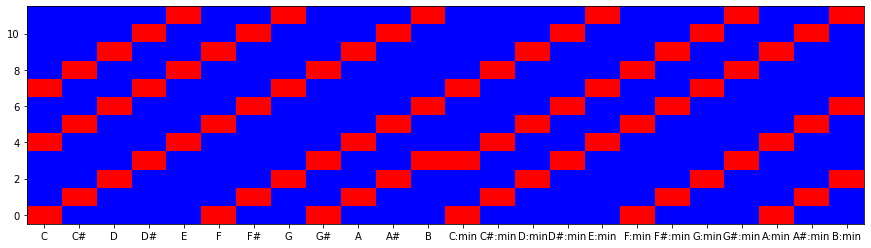

In [194]:
templates = generate_template_matrix(np.concatenate((template_cmaj,template_cmin), axis = 1))

plt.figure(figsize=(15,4))
plt.imshow(templates, origin="lower", aspect = "auto", cmap = "bwr")

chroma_labels = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
chroma_labels_maj = chroma_labels
chroma_labels_min = [s+':min' for s in chroma_labels]
chroma_labels = np.concatenate((chroma_labels_maj, chroma_labels_min), axis = 0)
plt.xticks(np.arange(24), chroma_labels)

In [195]:
def normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    """Normalizes the columns of a feature sequence

    Args:
        X: Feature sequence
        norm: The norm to be applied. '1', '2', 'max'
        threshold: An+ threshold below which the vector `v` used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm

    Returns:
        X_norm: Normalized feature sequence
    """
    
    K, N = X.shape
    X_norm = np.zeros((K,N))
    #print("this is K")
    #print(K)
    if norm == '1':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.sum(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
                
    if norm == '2':
        if v is None:
            v = np.ones(K, dtype=np.float64) / np.sqrt(K)
        for n in np.arange(N):
            p = np.sqrt(np.sum(X[:,n]**2))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v   
    
    if norm == 'max':
        if v is None:
            v = np.ones(K, dtype=np.float64) / K
        for n in np.arange(N):
            p = np.max(np.abs(X[:,n]))
            if p > threshold:
                X_norm[:,n] = X[:,n]/p
            else:
                X_norm[:,n] = v
    #print("this is v")
    #print(v)
    return X_norm

In [196]:
from scipy import signal

def smooth_downsample_feature_sequence(X, Fs, filt_len=41, down_sampling=10, w_type='boxcar'):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
        
    Hint: use numpy expand dims to obtain a window of dimension (1, L)
    """
    
    filter_kernel = np.expand_dims(signal.get_window(w_type, filt_len), axis=0)
    X_smooth =  signal.convolve(X, filter_kernel, mode='same') / filt_len 
    
    X_smooth = X_smooth[:, ::down_sampling]
    Fs_down = Fs / down_sampling
    
    return X_smooth, Fs_down

In [197]:
def analysis_template_match(chromagram, templates, Fs = 22050, hop_length = 2048, norm_chromagram = '2', norm_output ='2', 
                            smoothing_window_length = None, smoothing_down_sampling = None):
    
    chromagram_normalized = normalize_feature_sequence(chromagram, norm_chromagram)
    H = hop_length
    Fs_chroma = Fs / H
    
    if smoothing_down_sampling and smoothing_window_length:
        chromagram_normalized, Fs_feature = smooth_downsample_feature_sequence(chromagram_normalized, Fs_chroma,
                                                                           down_sampling=smoothing_down_sampling,
                                                                          filt_len=smoothing_window_length)
    else:
        Fs_feature = Fs / H 
    template_normalized = normalize_feature_sequence(templates,    
                                                     norm = norm_chromagram)
    
    chord_similarity = np.matmul(template_normalized.T, chromagram_normalized)
    
    if norm_output:
        chord_similarity = normalize_feature_sequence(chord_similarity, norm=norm_output)
        
    chord_max_labels = (chord_similarity == chord_similarity.max(axis = 0)).astype(int) #boolean matrix
    
    
    return chord_similarity, chord_max_labels, Fs_feature


In [198]:
fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
#fn_wav = os.path.join('data', 'wav', 'Beatles_HereComesTheSun.wav')
Fs = 22050
x,Fs = librosa.load(fn_wav, sr=Fs)


N = 4096
H = 2048
X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
X = np.abs(X)**2

C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)

chord_sim, chord_max, Fs_feature = analysis_template_match(C, templates, 
                                               smoothing_window_length=7, 
                                               smoothing_down_sampling=7,
                                               norm_chromagram = '2', 
                                               norm_output = 'max')

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.55064663 0.21744373 0.24004515 ... 0.62614436 0.89528144 1.        ]
 [0.52595111 0.0325752  0.04517378 ... 0.5436882  0.86387253 1.        ]
 ...
 [0.91571661 0.94501987 0.89956193 ... 0.8090996  0.9445782  1.        ]
 [0.52966266 0.20919273 0.2211301  ... 0.40595561 0.84878478 1.        ]
 [0.62880793 0.15670241 0.15857882 ... 0.43343797 0.87512252 1.        ]]
[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


([<matplotlib.axis.YTick at 0x1edda068a60>,
 [Text(0, 0, 'C'),
  Text(0, 1, 'C#'),
  Text(0, 2, 'D'),
  Text(0, 3, 'D#'),
  Text(0, 4, 'E'),
  Text(0, 5, 'F'),
  Text(0, 6, 'F#'),
  Text(0, 7, 'G'),
  Text(0, 8, 'G#'),
  Text(0, 9, 'A'),
  Text(0, 10, 'A#'),
  Text(0, 11, 'B'),
  Text(0, 12, 'C:min'),
  Text(0, 13, 'C#:min'),
  Text(0, 14, 'D:min'),
  Text(0, 15, 'D#:min'),
  Text(0, 16, 'E:min'),
  Text(0, 17, 'F:min'),
  Text(0, 18, 'F#:min'),
  Text(0, 19, 'G:min'),
  Text(0, 20, 'G#:min'),
  Text(0, 21, 'A:min'),
  Text(0, 22, 'A#:min'),
  Text(0, 23, 'B:min')])

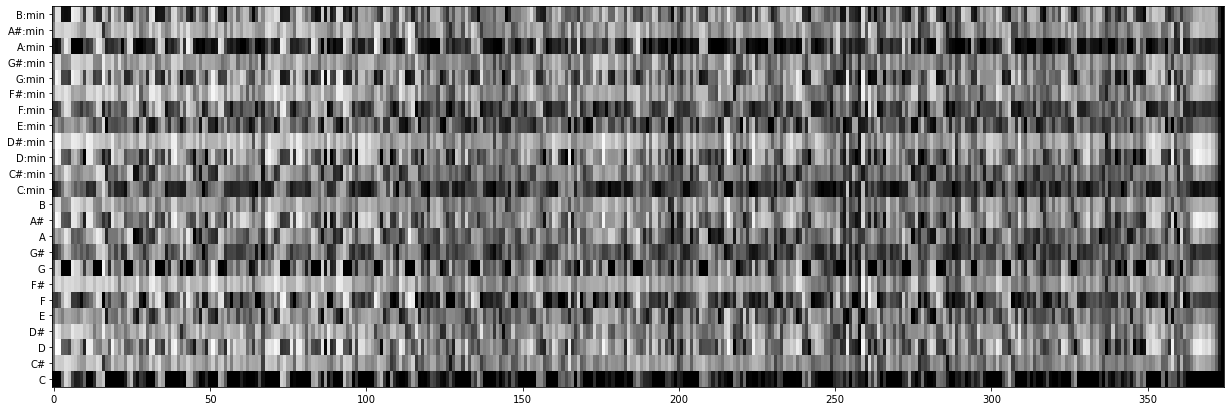

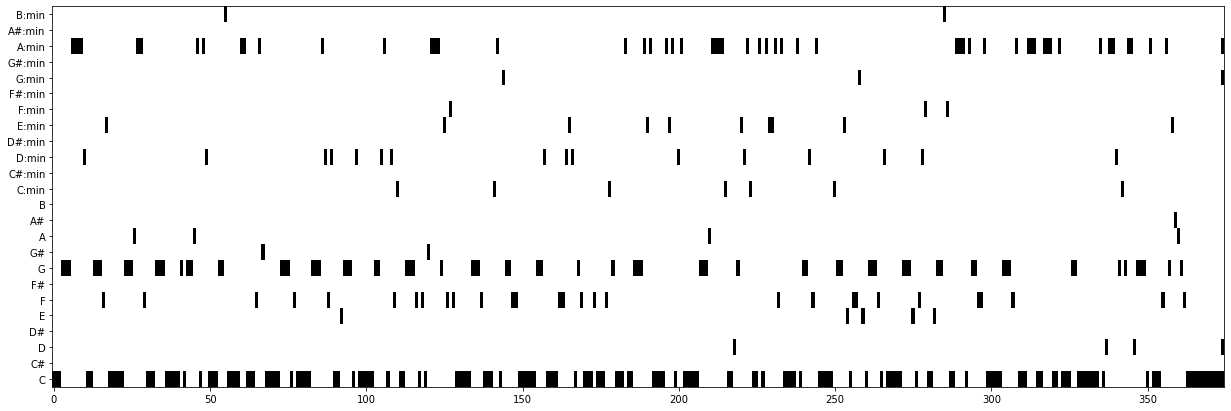

In [199]:
print(chord_sim)
print(chord_max)

fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_sim, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)

fig = plt.figure(figsize=(21, 7))
plt.imshow(chord_max, origin='lower', aspect='auto', cmap = 'gray_r')
plt.yticks(np.arange(24), chroma_labels)


In [200]:
def computeChordListEval(filePath, Fs=22050, N=4096, H=2048, smoothing_window_length=None, smoothing_down_sampling=None):
    
    x,Fs = librosa.load(filePath, sr=Fs)
    X = librosa.stft(x, n_fft = N, hop_length = H, pad_mode = 'constant', center = True)
    X = np.abs(X)**2
    C = librosa.feature.chroma_stft(S=X, sr = Fs, tuning = 0, hop_length = H, n_fft = N)
    
    chord_sim, chord_max, Fs_feature = analysis_template_match(C, templates, 
                                                  hop_length = H,
                                                  smoothing_window_length=smoothing_window_length, 
                                                  smoothing_down_sampling=smoothing_down_sampling,
                                                  norm_chromagram = '2', 
                                                  norm_output = 'max')
    K, N = chord_max.shape
    #print(K)
    chordList = []
    for i in np.arange(N):
        pos = chord_max[:,i]
        #print(pos)
        maxPos = np.where(pos != 0)
        #print(maxPos)
        if maxPos[0].size == 1:
            #print(len(maxPos))
            chordList.append(chroma_labels[maxPos[0].item(0)])
            #print(chordList)
        elif maxPos[0].size == 0:
            print("vuoto(?)")
        else:
            #print("stupido")
            #print(len(maxPos))
            chordList.append("random")
    
    return chordList, Fs_feature

In [201]:
# fn_wav = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
# fn_wav = os.path.join('data', 'wav', 'Beatles_HereComesTheSun.wav')
fn_wav = os.path.join('data', 'wav', 'Beatles_ObLaDiObLaDa.wav')


chordListValue, Fs_featureVal = computeChordListEval(fn_wav, smoothing_window_length=7, smoothing_down_sampling=7)
print(chordListValue)
# print(len(chordListValue))
print(Fs_featureVal)

['F', 'F', 'A:min', 'D:min', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#:min', 'D', 'A#', 'A#:min', 'F', 'F', 'F', 'F', 'C:min', 'A:min', 'A#', 'A#', 'D:min', 'F', 'A#', 'A#', 'D#:min', 'G:min', 'D#', 'G:min', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'D:min', 'G:min', 'F', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'D:min', 'A#', 'F', 'D:min', 'D#', 'G', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'D:min', 'A#', 'F', 'F', 'F', 'F', 'F', 'C:min', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'G:min', 'G', 'A#', 'A#', 'F', 'C', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'D:min', 'G:min', 'A#', 'G:min', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'D:min', 'D:min', 'A#', 'F', 'F', 'F', 'A#', 'A#:min', 'G:min', 'D#:min', 'A#', 'D#', 'D#', 'D#', 'D#', 'A#', 'D', 'A#:min', 'A#:min', 'A#', 'A#', 'G#', 'D#', 'D#', 'D#', 'A#', 'D#', 'E:min', 'D:min', 'D:min', 'A#', 'D:min', 'F:min', 'F', 'F', 'A#', 'D:min', 'D:min', 'F', 'F', 'F', 'A#:min', 'F

#### Question 2

In [202]:
def loadCSV(csvFileName, Fs_value):
    
    with open(csvFileName, newline='') as csvfile:
            
        reader = csv.DictReader(csvfile)
        out_list = []
        timeAccumulator = 0
        
        for row in reader:
            # while (timeAccumulator <= float(row['End'])) or ((timeAccumulator-float(row['End'])) < (1/(2*Fs_value))):
            while (timeAccumulator <= float(row['End'])):
                out_list.append(row['Label'])
                timeAccumulator += 1/Fs_value

    # if ((timeAccumulator<=float(row['End']))and(timeAccumulator-float(row['End'])) >= (1/(2*Fs_value))):
            #  out_list.append(row['Label'])
        
            
        return out_list, float(row['End'])
                


In [203]:
obla = "./data/csv/Beatles_ObLaDiObLaDa.csv"
letit = "./data/csv/Beatles_LetItBe.csv"
here = "./data/csv/Beatles_HereComesTheSun.csv"

myList, end = loadCSV(obla, Fs_feature)


In [204]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')

def stripList (chord_list, chroma_labels):
    
    comp_list = []
    chroma_labels = list(chroma_labels)
    L = len(chroma_labels)
    
    for i in np.arange(len(chord_list)):
        
        chord = chord_list[i]

        if(len(chord)>1):
            
            if (chord[1] == 'b'):
                index = (chroma_labels.index(chord[0])-1)%L
                enharmonic_chord = chroma_labels[index]
                old_chord = chord[:2]
                chord = chord.replace(old_chord, enharmonic_chord)
                
            if (('min' in chord) or ('dim' in chord)):
                index = chord.index(':')+1
                chord = chord[:index]+'min'
                
                comp_list.append(chord)
                
            else:
                if chord[1]==':':
                    comp_list.append(chord[0])
                else:
                    comp_list.append(chord[:2])

        else:
            comp_list.append(chord)
            
    return comp_list

comp = stripList(myList, chroma_labelsNames)
print(comp)


['F', 'F', 'F', 'D', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'D#', 'D#', 'D#', 'D#', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'G:min', 'G:min', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'G:min', 'G:min', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'D#', 'D#', 'D#', 'D#', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'G:min', 'G:min', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'F', 'F', 'G:min', 'G:min', 'A#', 'F', 'F', 'A#', 'A#', 'A#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'A#', 'A#', 'A#', 'F', 'F', 'F', 'A#', 'A#', 'A#', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'A#', 'A#', 'A#', 'A#', 'A#', 'A#', 'D#', 'D#', 'D#', 'D#', 'A#', 'F', 'F', 'A#',

Question 3

In [205]:

def compute_goodness(chord_list, ground_truth_list):
    L = len(chord_list)
    L_gt = len(ground_truth_list)
    counter = 0
    if L==L_gt:
        for i in np.arange(len(chord_list)):
            if chord_list[i] == ground_truth_list[i]:
                counter += 1
        goodness = counter/L
        return goodness
    else:
        print('Lists must have same length!')
        print('L_chord: ', L)
        print('L_gt: ', L_gt)
        
compute_goodness(chordListValue, comp)



0.6185567010309279

##### Question 4   


In [206]:
chroma_labels_names = ('C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B')
songs= ['HereComesTheSun','LetItBe','ObLaDiObLaDa','PennyLane']
for title in songs:
    wavFile = 'Beatles_' + title + '.wav'
    csvFile = 'Beatles_' + title + '.csv'
    #print(wavFile)
    sourceWav = os.path.join('data', 'wav', wavFile)
    sourceCSV = os.path.join('data', 'csv', csvFile)
    #print(sourceWav)
    computedChordList, Fs_feature = computeChordListEval(sourceWav, smoothing_window_length=7, smoothing_down_sampling=7)
    ground_truth_List, timeLength = loadCSV(sourceCSV,Fs_feature)
    ground_truth_List_stripped = stripList(ground_truth_List,chroma_labels_names)
    metric_value = compute_goodness(computedChordList,ground_truth_List_stripped)
    print(title + " metric goodness: " + str(metric_value))

HereComesTheSun metric goodness: 0.5594405594405595
LetItBe metric goodness: 0.6293333333333333
ObLaDiObLaDa metric goodness: 0.6185567010309279
PennyLane metric goodness: 0.4911660777385159
